## Towards Marginal Likelihood in Julia (AIS / GRIS / MC-IS / AMIS)
Our alphabet soup here:
* Annealed Importance Sampling
* Gradient Importance Sampling
* Monte-Carlo Importance Sampling
* Adaptive Mixture Importance Sampling

My belief is that these ideas are each fairly powerful and while often overlapping, also to a certain extent complementary. If used together, particularly if finished off with defensive importance sampling, may prove to be a useful way to calculate the evidence / marginal likelihood of a probabilistic model. This is something like part III or IV of a bunch of notebooks exploring these kinds of ideas (and teaching myself Julia!)

Cappé, O., Douc, R., Guillin, A., Marin, J. M., & Robert, C. P. (2008). Adaptive importance sampling in general mixture classes. Statistics and Computing, 18(4), 447-459.<br>
Neal, R. M. (2001). Annealed importance sampling. Statistics and computing, 11(2), 125-139.<br>
Schuster, I. (2015). Gradient importance sampling. arXiv preprint arXiv:1507.05781.<br>
Del Moral, P., Doucet, A., & Jasra, A. (2006). Sequential monte carlo samplers. Journal of the Royal Statistical Society: Series B (Statistical Methodology), 68(3), 411-436.<br>

@article{cappe2008adaptive,
  title={{Adaptive Importance Sampling in General Mixture Classes}},
  author={Capp{\'e}, Olivier and Douc, Randal and Guillin, Arnaud and Marin, Jean-Michel and Robert, Christian P},
  journal={Statistics and Computing},
  volume={18},
  number={4},
  pages={447--459},
  year={2008},
  publisher={Springer}
}
@article{neal2001annealed,
  title={{Annealed Importance Sampling}},
  author={Neal, Radford M},
  journal={Statistics and computing},
  volume={11},
  number={2},
  pages={125--139},
  year={2001},
  publisher={Springer}
}
@article{schuster2015gradient,
  title={{Gradient Importance Sampling}},
  author={Schuster, Ingmar},
  journal={arXiv preprint arXiv:1507.05781},
  year={2015}
}
@article{del2006sequential,
  title={{Sequential Monte Carlo Samplers}},
  author={Del Moral, Pierre and Doucet, Arnaud and Jasra, Ajay},
  journal={Journal of the Royal Statistical Society: Series B (Statistical Methodology)},
  volume={68},
  number={3},
  pages={411--436},
  year={2006},
  publisher={Wiley Online Library}
}

To prevent another wholesale repetition from previous notebooks, I've included the most useful functions so far into a 'utils' package

In [315]:
include("./abutils.jl")

Main.abutils

In [2]:
splat = abutils.unpack_arr
gaussian_2D_level_curve = abutils.gaussian_2D_level_curve

gaussian_2D_level_curve (generic function with 3 methods)

In [572]:
using PyPlot
using Distributions
using LinearAlgebra
using Formatting
using Flux
using Flux: Tracker
using StatsBase
using Clustering
using Parameters
using Random

### Setup a toy problem

In [4]:
function gen_gauss_mix(k; d=2)
    mus = 20 .* rand(k, d) .- 10
    covs = randn(d, d, k)
    UT = []
    for i in range(1, stop=k)
        covs[:,:,i] = covs[:,:,i] * covs[:,:,i]' + 0.1*Matrix(I, d, d)
        push!(UT, cholesky(covs[:,:,i]).U)
    end
    return mus, covs, UT
end

gen_gauss_mix (generic function with 1 method)

In [5]:
_mus, _covs, _UTs = gen_gauss_mix(4);

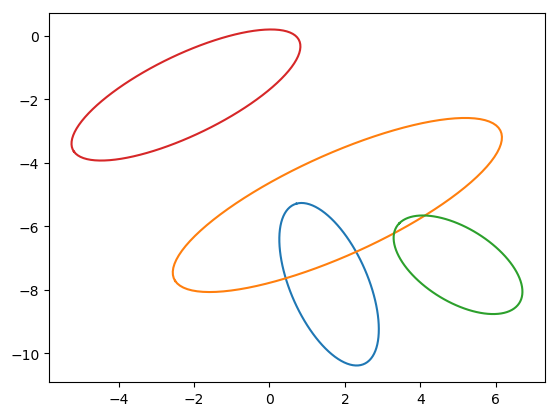

In [6]:
for i = 1:4
    plot(splat(abutils.gaussian_2D_level_curve(_mus[i,:], _covs[:,:,i]))...)
end

In [7]:
const mus =  [-8.24792   -7.22486;
               1.88523    0.470692;
              -6.16808    8.5335;
               0.273647   3.00132]

const UTs = [[1.86038 0.869847; 0.0 0.414693], [1.32273 0.0985234; 0.0 0.363965], [1.16059 -0.23332; 0.0 0.480219],[0.318648 0.277103; 0.0 2.4839]]
const invUTs = [Matrix(cholesky(inv(x'*x)).U) for x in UTs]
const mixpi = [.25 for i in 1:4]
tmp=zeros(8, 8); for ii=1:2:8; tmp[ii:ii+1, ii:ii+1] = invUTs[(ii ÷ 2) + 1]; end;
const invUTBlk = tmp;

In [8]:
(invUTs[1]'*invUTs[1]) * UTs[1]'UTs[1]

2×2 Array{Float64,2}:
 1.0          -4.44089e-16
 1.77636e-15   1.0        

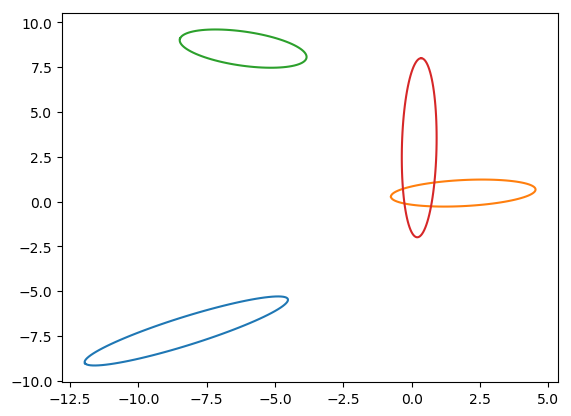

In [9]:
for i = 1:4
    plot(splat(abutils.gaussian_2D_level_curve(mus[i,:],UTs[i]'UTs[i]))...)
end

### Define the key logsumexp / softmax functions for autograd

In [10]:
# yanked from https://github.com/JuliaStats/StatsFuns.jl/blob/master/src/basicfuns.jl
# with a couple of mods


using Flux.Tracker: TrackedReal, track, @grad


function logsumexp(X::AbstractArray{T}) where {T<:Real}
    isempty(X) && return log(zero(T))
    u = maximum(X)
    isfinite(u) || return float(u)
    let u=u # avoid https://github.com/JuliaLang/julia/issues/15276
        u + log.(sum(x -> exp.(x-u), X))
    end
end

function logsumexprows(X::AbstractArray{T}) where {T<:Real}
    n = size(X,1)
    out = zeros(n)
    for i = 1:n
        out[i] = logsumexp(X[i,:])
    end
    return out
end   


function softmax2(logp; dims=2)
    p = exp.(logp .- maximum(logp, dims=dims))
    p ./= sum(p, dims=dims)
    return p
end

# PLUG INTO FLUX
logsumexprows(X::TrackedArray) = Tracker.track(logsumexprows, X)

@grad function logsumexprows(X)
  return logsumexprows(X.data), Δ -> (Δ .* softmax2(Δ.*X.data),)
end

In [116]:
function softmaxbatch(logp; dims=2)
    u = maximum(logp, dims=dims)
#     u = (dims == 2) ? u : u'
    p = exp.(logp .- u)
    return p / sum(p)
end

softmaxbatch (generic function with 1 method)

#### Testing logsumexprows gradient (in an ad-hoc way)

In [137]:
using Flux.NNlib

In [177]:
softmax2([1. 3. 4.; 2. 4.4 1.9]; dims=2)

2×3 Array{Float64,2}:
 0.035119   0.259496  0.705385 
 0.0773514  0.852658  0.0699904

In [174]:
softmax2([1. 3. 4.]; dims=2)

1×3 Array{Float64,2}:
 0.035119  0.259496  0.705385

In [138]:
softmax([1 3 4])

LoadError: MethodError: no method matching softmax!(::Array{Int64,2}, ::Array{Int64,2})
Closest candidates are:
  softmax!(::Any) at /Users/abird/.julia/packages/NNlib/6sh6c/src/softmax.jl:28

In [189]:
a = [1. 3. 4.; 2. 4.4 1.9]
a = Tracker.param(a)
Tracker.back!(sum(prod(logsumexprows(sin.(a.^2)) , dims=2)))
a.grad

2×3 Array{Float64,2}:
  0.547373  -1.80253  -1.2544  
 -0.44837    4.5746   -0.789096

In [182]:
abutils.num_grad(x -> prod(logsumexprows(sin.(x.^2)), dims=2), [1. 3. 4.; 2. 4.4 1.9])

2×6 Array{Float64,2}:
 0.547373   0.0      -1.80253  0.0     -1.2544   0.0     
 0.0       -0.44837   0.0      4.5746   0.0     -0.789096

### Define the log probabilities
These have some tests just to make sure too

In [312]:
# model definition
const prop_var = 10.0^2
# implicitly proposal mean is 0

function p_log_prop(X)
    @assert ndims(X) == 2
    n, d = size(X)
    @assert d != 1
    Z = X .* (1/sqrt(prop_var))
    exponent = -0.5*sum(Z.^2, dims=2)
    lognormconst = -(d/2)*log(2*pi*prop_var)
    return exponent .+ lognormconst
end

function _p_log_target_component(X, i)
    d = size(X,2)
    Z = (X .- mus[i,:]')*invUTs[i]'
    exponent = -0.5*sum(Z.^2, dims=2)
    lognormconst = -d*log(2*pi)/2 .- sum(log.(diag(UTs[i])))
    return exponent .+ lognormconst .+ log(mixpi[i])
end

# function p_log_target(X)
#     @assert ndims(X) == 2
#     n, d = size(X)
#     @assert d != 1
    
#     P = reduce(hcat, map(ix -> _p_log_target_component(X, ix), 1:4))
#     return logsumexprows(P) # added manually to Flux in this notebook
# end

function p_log_target(X)
    @assert ndims(X) == 2
    n, d = size(X)
    @assert d != 1
    
    dupmat = reduce(hcat, [Matrix(I, 2, 2) for i in 1:4])
    Msumadj = zeros(Bool, 8,4); for ii=0:3; Msumadj[ii*2 + 1:(ii+1)*2, ii+1] .= true; end
    
    Xdup = X * dupmat
    Xcenter = Xdup .- reshape(mus', 1, 8)
    Z = Xcenter * invUTBlk'
    exponent = -0.5*((Z.^2) * Msumadj)
    lognormconst = -d*log(2*pi)/2 .- [sum(log.(diag(UTs[i]))) for i in 1:4]
    P = exponent .+ lognormconst' .+ [log(mixpi[i]) for i in 1:4]'
    return logsumexprows(P) # FLUX: ADDED ABOVE
end

q_log_beta(x, beta) = (1-beta)*p_log_prop(x) + beta*p_log_target(x)
eff_ss(W) = 1/sum((W./sum(W)).^2)
weight_perp(W) = let w=W/sum(W); -sum(w.* log.(w))/log(length(W)) end

function p_log_beta(x, beta)
    f_x = p_log_target(x)
    return (1-beta)*p_log_prop(x) + beta*f_x, f_x
end

p_log_beta (generic function with 1 method)

##### Test Proposal Density vs. julia builtin

In [12]:
maxdelta = 0
for i in range(1, stop=1000)
    x = randn(1,2)*100
    Δ = abs.(logpdf(MvNormal([0; 0], 1e4*abutils.eye(2)), x') - p_log_prop(x))[1,1]
    if Δ > 1e-6
        print(x)
        println(" Delta is " * sprintf1(".7f", Δ))
    end
    global maxdelta = max(maxdelta, Δ)
end
println("maxdelta"); maxdelta

maxdelta


3.552713678800501e-15

In [149]:
abutils.num_grad(abutils.logsumexp, [20., 21.])

1×2 Array{Float64,2}:
 0.268941  0.731059

##### Test Target Density vs. julia builtin

In [13]:
maxdelta = 0
for i in range(1, stop=1000)
    x = randn(1,2)*100
    jlmvn = zeros(4)
    for j = 1:4
        jlmvn[j] = (logpdf(MvNormal(vec(mus[j,:]), UTs[j]'UTs[j]), x') .+ log(mixpi[j]))[1]
    end
    jlmvn = logsumexp(jlmvn)
    Δ = abs.(jlmvn - p_log_target(x)[1])
    if Δ > 1e-6
        println(i)
        print(x)
        print(jlmvn); print("  "); println(p_log_target(x))
        println(" Delta is " * sprintf1("%.7f", Δ))
    end
    global maxdelta = max(maxdelta, Δ)
end
println("maxdelta"); maxdelta

maxdelta


2.9103830456733704e-11

In [25]:
maxdelta = 0
for i in range(1, stop=1000)
    x = randn(1,2)*100
    Δ = abs.(p_log_target(x)[1] - p_log_target_flux(x)[1])
    if Δ > 1e-6
        println(i)
        print(x)
        print(jlmvn); print("  "); println(p_log_target(x))
        println(" Delta is " * sprintf1("%.7f", Δ))
    end
    global maxdelta = max(maxdelta, Δ)
end
println("maxdelta"); maxdelta

maxdelta


0.0

##### Other useful things

In [187]:
function plot_level_curves_all(mus, UTs; ax=Nothing, kwargs...)
    ax = ax==Nothing ? gca() : ax
    for i = 1:4
        ax[:plot](splat(gaussian_2D_level_curve(mus[i,:], UTs[i]'*UTs[i]))...; kwargs...);
    end
end

function plot_is_vs_target(S, W; ax=Nothing, kwargs...)
    rgba_colors = zeros(size(S, 1), 4)
    rgba_colors[:, 3] .= 1.0   # blue
    rgba_colors[:, 4] = W/maximum(W)   # alpha
#     print(rgba_colors)
    ax = ax==Nothing ? gca() : ax
    plot_level_curves_all(mus, UTs; ax=ax)
    ax[:scatter](splat(S)..., c=rgba_colors)
end

plot_is_vs_target (generic function with 1 method)

In [33]:
function eta_t(t)
    delta = 0.1
    return delta * exp(-0.02 * t)
end

eta_t (generic function with 1 method)

In [34]:
macro noopwhen(condition, expression)
    quote
        if !($condition)
            $expression
        end
    end |> esc
end

@noopwhen (macro with 1 method)

### Re-introducing GRIS!

In [54]:
function gradient_importance_sample_gauss(epochs, n_samples, log_f; burnin=0, test=true)
    @assert burnin < epochs
    
    sqrtdelta = 1
    S = zeros(n_samples*epochs, 2)
    W = zeros(n_samples*epochs)
    
    # Make initial proposal from prior
    μ_init = [0 0]'
    x = randn(n_samples, 2) .* 10 .+ μ_init'
    S[1:n_samples,:] = x
    
    # ... allow for resampling of all (in principle)
    W[1:n_samples] .= 1
    
    @noopwhen !test f, axs = PyPlot.subplots(11,3, figsize=(10,20))
    @noopwhen !test axs[1,1][:scatter](splat(x)...)
    @noopwhen !test plot_is_vs_target(S[1:n_samples,:], exp.(W[1:n_samples]), ax=axs[1,2])
    @noopwhen !test display(reduce(hcat, [S[1:n_samples,1], S[1:n_samples,2], W[1:n_samples], log_f(x)]))
    
    # ===> GRIS LOOP <====
    for t = range(1, stop=epochs)
        
        nodisp = (!test || t>10)
        # sample previous particles for this epoch
        begin
            min_rng = 1 + max(0, n_samples*t-1200)
            max_rng = n_samples*max(1, t-1)
            ixs = abutils.smp_from_logprob(n_samples, W[min_rng:max_rng])  .+ min_rng
        end
        
        x = S[ixs,:]
        
        @noopwhen nodisp axs[t+1,1][:scatter](splat(x)...)
        @noopwhen nodisp plot_level_curves_all(mus, UTs, ax=axs[t+1,1], color="red")
        
        # get gradient / Langevin proposal
        # --- calculate gradient ---
        η = eta_t(t)  
        x_track = param(x)
        lp = log_f(x_track)
        Tracker.back!(sum(lp))
        
        c_mus = x .+ 1.0.*η .* x_track.grad
        # --------------------------

        @noopwhen nodisp axs[t+1,2][:scatter](splat(c_mus)...)
        @noopwhen nodisp plot_level_curves_all(mus, UTs, ax=axs[t+1,2], color="red")
        
        # Sample from proposal
        xprime = c_mus .+ sqrtdelta*randn(n_samples, 2)
        @noopwhen nodisp axs[t+1,3][:scatter](splat(xprime)...)
        @noopwhen nodisp plot_level_curves_all(mus, UTs, ax=axs[t+1,3], color="red")
        
        # calculate importance weight
        begin
            dist_metric = abutils.sq_diff_matrix(xprime, c_mus) ./ (2*sqrtdelta^2)
            lq_u = logsumexprows(-dist_metric) .- log(Float64(n_samples)) .- 0.5*2*log(2*pi*sqrtdelta^2)
            
            @noopwhen !test begin
                lq_u2 = logsumexprows(-dist_metric) .- log(Float64(n_samples)) .- 0.5*log(det(2*pi*sqrtdelta^2 * eye(2)))
                q_n = mapslices(x -> [mean([pdf(MvNormal(c_mus[i,:], sqrtdelta^2*eye(2)), x) 
                                      for i in 1:n_samples])], xprime, dims=2)
                print(unique(map(x->round(x, digits=5), exp.(lq_u2) ./exp.(lq_u))))   # ratio to exact quick calc
                println(unique(map(x->round(x, digits=5), q_n ./exp.(lq_u))))  # ratio to built-in Julia MVN
            end
                         
            w = log_f(xprime) .- lq_u  # may be able to get rid of f_log_target if we resample as in Schuster
                                            # i.e. calculate in the gradient block in next iter.
        end
        
        # Store particles / weights
        S[1+n_samples*(t-1):n_samples*t, :] = xprime
        W[1+n_samples*(t-1):n_samples*t] = w
    end
    
    if burnin > 0
        S = S[n_samples*burnin+1:end, :]; W = W[n_samples*burnin+1:end]
    end
    
    return S, abutils.fastexp.(W)
end

gradient_importance_sample_gauss (generic function with 1 method)

In [79]:
p_log_target([11. 0; 1. 5])

2-element Array{Float64,1}:
 -31.223511026000722
  -5.739802244294825

In [59]:
p_log_target([5. 5])

1-element Array{Float64,1}:
 -52.536979154657715

50×4 Array{Float64,2}:
 -11.5804     3.22729    1.0  -102.159  
   1.71749   -7.13015    1.0   -23.7641 
  -1.02615   18.9156     1.0   -34.8537 
   7.87434  -12.2807     1.0  -326.31   
  -1.16012   -0.568642   1.0    -7.63253
  11.1288    -8.79264    1.0  -385.595  
  -3.9602    18.6398     1.0  -121.512  
  -3.58707  -16.2906     1.0   -96.9652 
   4.1982    14.2203     1.0   -83.7737 
   3.03961    0.0441026  1.0    -3.86566
  -5.37538    4.8892     1.0   -29.2047 
   8.35602    0.923483   1.0   -14.4622 
  -4.85903   -1.47308    1.0   -23.3339 
   ⋮                                    
  -6.55246  -13.6348     1.0  -154.215  
  11.4762     0.806728   1.0   -29.3213 
 -10.5047   -21.6919     1.0  -526.687  
  11.4172    10.7046     1.0  -188.032  
  -0.95545   -6.36899    1.0   -16.0143 
  -6.17326  -14.3797     1.0  -195.519  
   0.32285    5.7002     1.0    -3.57398
   7.37269  -12.1726     1.0  -288.09   
  -5.38635   13.7733     1.0   -66.0192 
 -16.7234     3.86946    1.0  -143

[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]
[1.0][1.0]


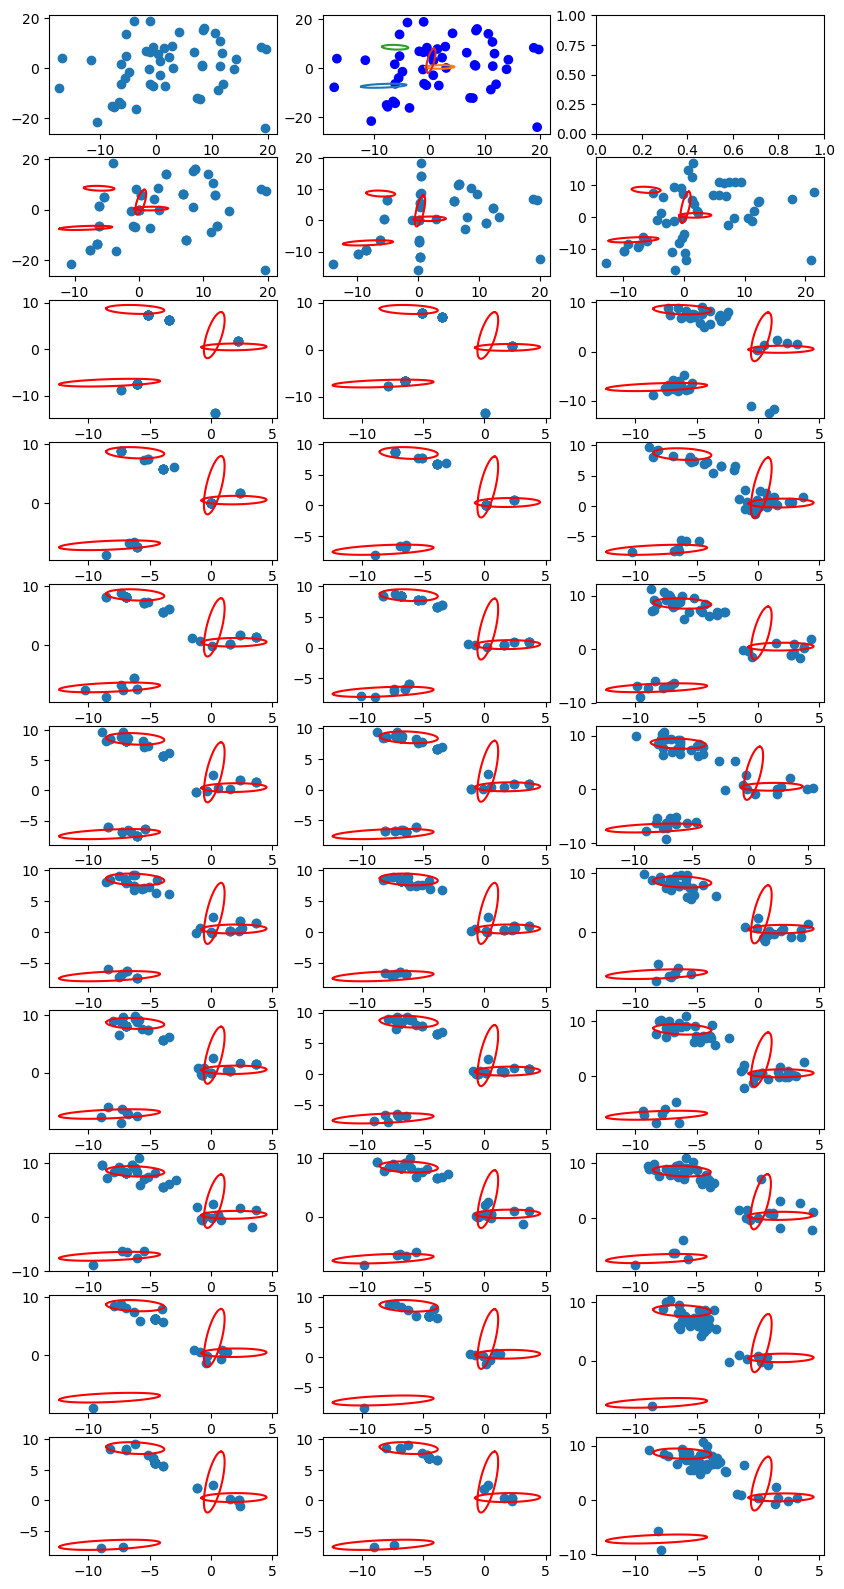

[1.0][1.0]


([-10.2416 -9.60641; 0.747246 -0.0815495; … ; -8.55061 9.07269; -7.5954 9.80867], [0.0998817, 2.38408, 3.71353, 9.99362e-5, 5.71019, 3.85615, 0.372834, 0.00716222, 0.000648501, 0.000784286  …  0.0139091, 0.0961292, 2.91929, 4.0436, 7.27987e-5, 0.000225568, 0.274626, 0.000621151, 0.367955, 0.199235])

In [80]:
S, W = gradient_importance_sample_gauss(50, 50, p_log_target, burnin=20, test=true)

### Issues
* Due to the resampling stage, particles are not given much time to explore the space initially. Only those that happen to hit the mark are typically chosen, and so the multi-modal aspects of the problem are undeveloped.
* If an unlikely sample from an existing atom happen to stumble upon an area of higher density, a huge weight is given. This is problematic not only for the current epoch, but for the next 20, since this weight is likely to be *much* higher than anything else that comes next. Thus a huge amount of sampling can be done in an unprofitable area.

Solutions
* Anneal the weights so we do not get rid of samples that are near the typical set at the expense of those right in the middle.
* Only resample every $L$ steps so that a sort of Langevin MC / descent idea is followed, allowing all particles to get near the different modes.

## Defining a SMC Samplers Approach
Here we blend GRIS with Langevin-like Markov Chains and annealing distributions.


In the below struct one can specify the annealing schedule in the `betas` parameter. The other key parameter is `resample_every` which gives the opportunity to run the chains closer to regions of high density before resampling. Essentially this is just a stronger proposal density which is defined by something not entirely dissimilar to MCMC.

In [100]:
@with_kw struct smcs_opt
    resample_every::Int64 = 1 
    sqrtdelta::Float64 =1.
    betas::Array{Float64} = [1.]
    test::Bool = false
    grad_delta::Float64 = 1.0
    burnin::Int64 = 0
end

smcs_opt

In [794]:
function smcs_grad(epochs, n_samples, log_f; opts=smcs_opt())
    @assert opts.burnin < epochs
    @assert isa(opts, smcs_opt)
    @assert epochs % opts.resample_every == 0 "epochs should be a multiple of the resampling points"
    
    @unpack test, resample_every, sqrtdelta, grad_delta = opts
    δ = grad_delta
    n_β = length(opts.betas)
    n_β > opts.burnin && println("WARNING: BURN IN SHORTER THAN ANNEALING TIME")
        
    S = zeros(n_samples*epochs, 2)
    W = zeros(n_samples*epochs)
    Wfinal = zeros(n_samples*epochs)
    
    # Make initial proposal from prior
    μ_init = [0 0]'
    x = randn(n_samples, 2) .* 10 .+ μ_init'
#     S[1:n_samples,:] = x
    
    @noopwhen !test f, axs = PyPlot.subplots(13,3, figsize=(10,22))
    @noopwhen !test axs[1,1][:scatter](splat(x)...)
    @noopwhen !test plot_is_vs_target(S[1:n_samples,:], exp.(W[1:n_samples]), ax=axs[1,2])
    @noopwhen !test display(reduce(hcat, [S[1:n_samples,1], S[1:n_samples,2], W[1:n_samples], log_f(x, opts.betas[1])[1]]))
    
    # ===> GRIS LOOP <====
    for t = range(1, stop=epochs)
        
        nodisp = (!test || t>12)
        β = opts.betas[min(t, n_β)]
        
        @noopwhen nodisp axs[t+1,1][:scatter](splat(x)...)
        @noopwhen nodisp plot_level_curves_all(mus, UTs, ax=axs[t+1,1], color="red")
        
        # get gradient / Langevin proposal
        # --- calculate gradient ---
        η = eta_t(t)  
        x_track = param(x)
        lp = log_f(x_track, 1.)[1]   # also spits out just log_f in second retval (a.o.to beta mix)
        Tracker.back!(sum(lp))
        
        c_mus = x .+ δ.*η .* x_track.grad
        # --------------------------

        @noopwhen nodisp axs[t+1,2][:scatter](splat(c_mus)...)
        @noopwhen nodisp plot_level_curves_all(mus, UTs, ax=axs[t+1,2], color="red")
        
        # Sample from proposal
        xprime = c_mus .+ sqrtdelta*randn(n_samples, 2)
        @noopwhen nodisp axs[t+1,3][:scatter](splat(xprime)...)
        @noopwhen nodisp plot_level_curves_all(mus, UTs, ax=axs[t+1,3], color="red")
        
        # calculate importance weight
        begin
            dist_metric = abutils.sq_diff_matrix(xprime, c_mus) ./ (2*sqrtdelta^2)
            lq_u = logsumexprows(-dist_metric) .- log(Float64(n_samples)) .- 0.5*2*log(2*pi*sqrtdelta^2)
            
            @noopwhen true begin
                lq_u2 = logsumexprows(-dist_metric) .- log(Float64(n_samples)) .- 0.5*log(det(2*pi*sqrtdelta^2 * eye(2)))
                q_n = mapslices(x -> [mean([pdf(MvNormal(c_mus[i,:], sqrtdelta^2*eye(2)), x) 
                                      for i in 1:n_samples])], xprime, dims=2)
                print(unique(map(x->round(x, digits=5), exp.(lq_u2) ./exp.(lq_u))))   # ratio to exact quick calc
                println(unique(map(x->round(x, digits=5), q_n ./exp.(lq_u))))  # ratio to built-in Julia MVN
            end
            
            l_anneal, lp = log_f(xprime, β)
            w = l_anneal .- lq_u  # may be able to get rid of f_log_target if we resample as in Schuster
                                           # i.e. calculate in the gradient block in next iter.
        end
        
        # Store particles / weights & Resample (or just continue!)
        S[1+n_samples*(t-1):n_samples*t, :] = xprime
        W[1+n_samples*(t-1):n_samples*t] = w
        Wfinal[1+n_samples*(t-1):n_samples*t] = lp .- lq_u
        
        if t % resample_every == 0
            # RESAMPLE
            begin
                min_rng = 1 + max(0, n_samples*t-1200)
                max_rng = n_samples*max(1, t-1)
                ixs = abutils.smp_from_logprob(n_samples, W[min_rng:max_rng])  .+ min_rng .- 1
                @noopwhen !test print("RESAMPLE.." * sprintf1("%d", min_rng) * " " * sprintf1("%d", max_rng))
                x = S[ixs,:]
                @noopwhen !test println(" Done!")
            end
        else
            x = xprime
        end
    end
    
    if opts.burnin > 0
        ix_start = n_samples*opts.burnin+1
        S = S[ix_start:end, :]; W = Wfinal[ix_start:end]
    end
    
    return S, abutils.fastexp.(W)
end

smcs_grad (generic function with 1 method)

50×4 Array{Float64,2}:
 0.0  0.0  0.0   -8.79399
 0.0  0.0  0.0  -12.5631 
 0.0  0.0  0.0   -8.74898
 0.0  0.0  0.0   -7.91295
 0.0  0.0  0.0   -9.81126
 0.0  0.0  0.0   -7.64336
 0.0  0.0  0.0   -8.87429
 0.0  0.0  0.0   -6.99554
 0.0  0.0  0.0   -6.73205
 0.0  0.0  0.0   -8.38124
 0.0  0.0  0.0   -7.72696
 0.0  0.0  0.0   -7.08187
 0.0  0.0  0.0  -12.9888 
 ⋮                       
 0.0  0.0  0.0   -7.10739
 0.0  0.0  0.0   -7.7377 
 0.0  0.0  0.0  -10.3348 
 0.0  0.0  0.0   -7.76577
 0.0  0.0  0.0   -6.89909
 0.0  0.0  0.0   -9.98131
 0.0  0.0  0.0   -7.78854
 0.0  0.0  0.0   -7.74702
 0.0  0.0  0.0   -6.64923
 0.0  0.0  0.0   -6.8209 
 0.0  0.0  0.0   -6.73324
 0.0  0.0  0.0   -8.14308

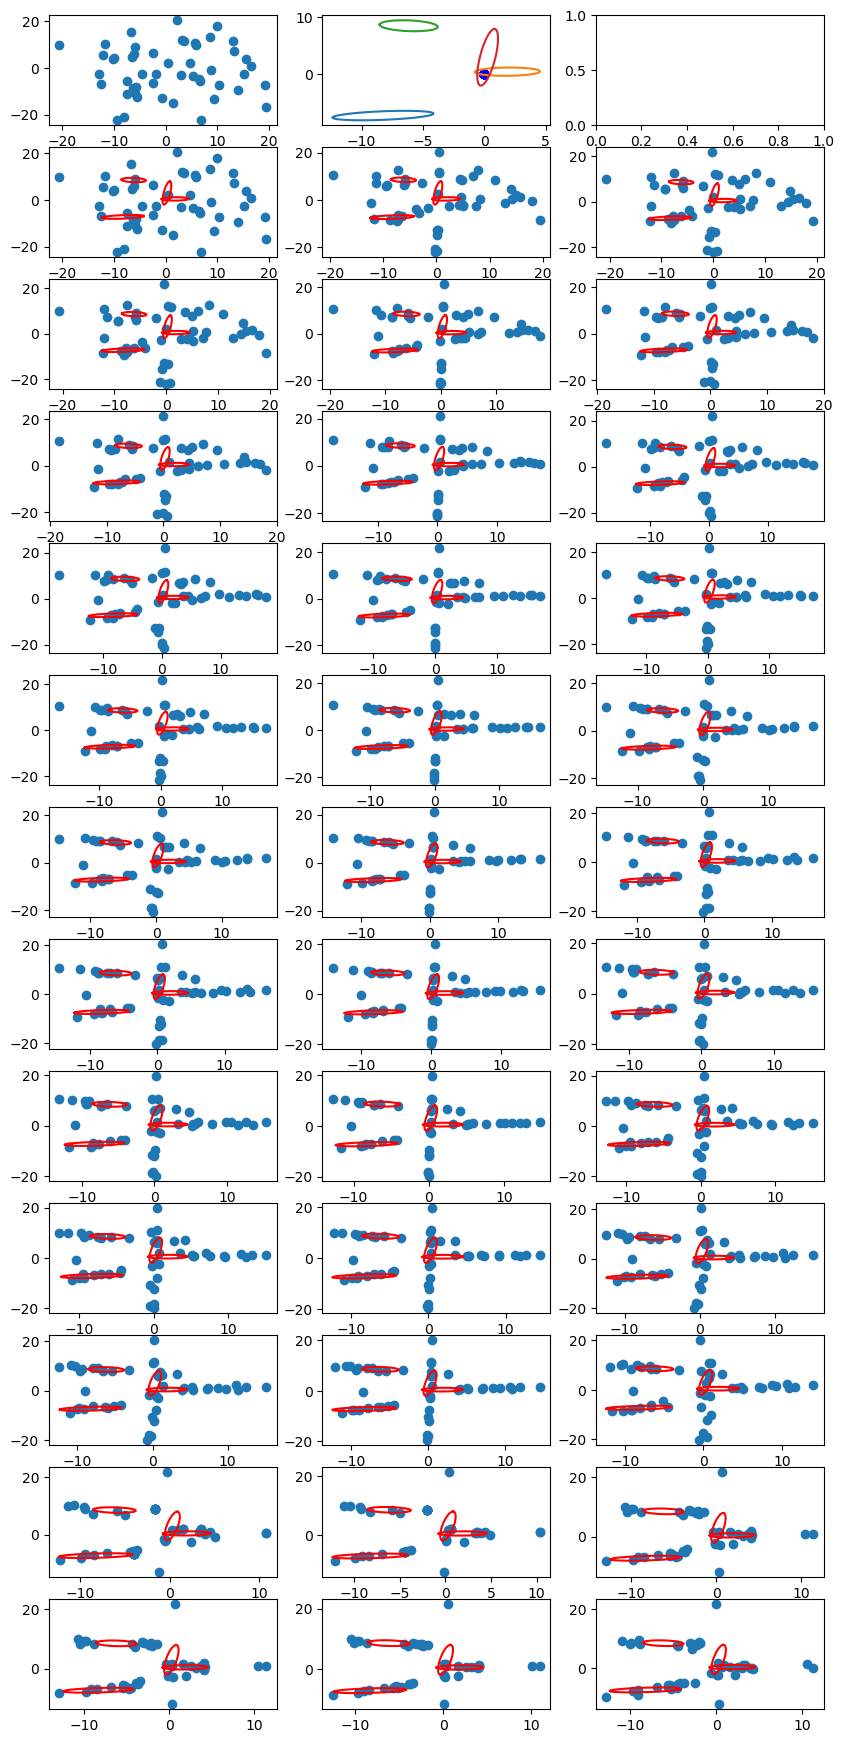

RESAMPLE..1 450 Done!
RESAMPLE..1 950 Done!
RESAMPLE..301 1450 Done!
RESAMPLE..801 1950 Done!
RESAMPLE..1301 2450 Done!
RESAMPLE..1801 2950 Done!
RESAMPLE..2301 3450 Done!
RESAMPLE..2801 3950 Done!


([0.397802 3.83038; 0.894911 4.64995; … ; -0.670649 2.14556; -7.12741 8.76861], [1.60978, 0.239348, 0.69285, 0.220167, 0.794365, 0.467208, 0.217842, 0.00296309, 0.00416871, 0.237542  …  1.94044, 0.0028295, 0.0179603, 0.402268, 0.56892, 0.0756765, 0.384326, 0.747676, 0.0257972, 2.98791])

In [185]:
c_opts = smcs_opt(resample_every=10, betas=range(0.01, stop=1., length=50), 
    burnin=50, test=true, grad_delta=1.0, sqrtdelta=0.5)
S, W = smcs_grad(80, 50, q_log_beta, opts=c_opts)

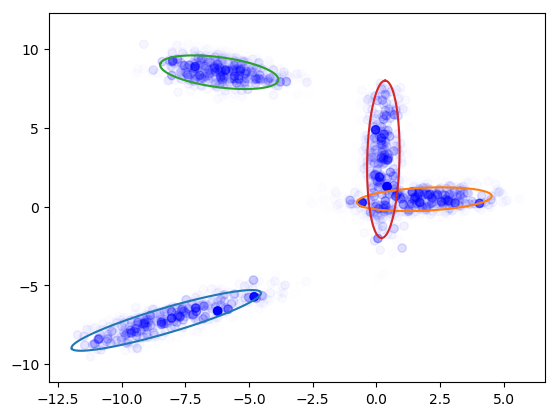

PyObject <matplotlib.collections.PathCollection object at 0xa65621748>

In [188]:
plot_is_vs_target(S, W)

#### Normalising Constant is close to 1

In [189]:
mean(W)

0.9836445909936238

#### Little visualisation of all the samples generated during the process

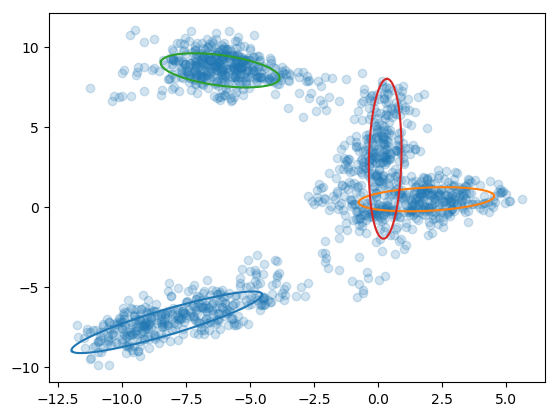

In [193]:
scatter(splat(S[W.>1e-40,:])..., alpha=0.2)
for i = 1:4; plot(splat(abutils.gaussian_2D_level_curve(mus[i,:],UTs[i]'UTs[i]))...); end

### Look at the distribution of estimates of the normalising constant.
We see there is a downward bias, and while the bias is perhaps only 3-4%, the individual estimates can be quite far off. Having said that, it is not as bad as we saw for GRIS.


<span style="color:red"><b>TODO: COMPARE WITH GRIS AND AIS AND VANILLA IS</b></span>

In [ ]:
c_opts = smcs_opt(resample_every=10, betas=range(0.01, stop=1., length=50), 
    burnin=50, test=false, grad_delta=1.0, sqrtdelta=0.5)

In [200]:
normconstest = zeros(1000,1)
for i = 1:1000
    S, W = smcs_grad(80, 50, q_log_beta, opts=c_opts)
    normconstest[i] = mean(W)
    i % 100 == 0 && println(i)
end

100
200
300
400
500
600
700
800
900
1000


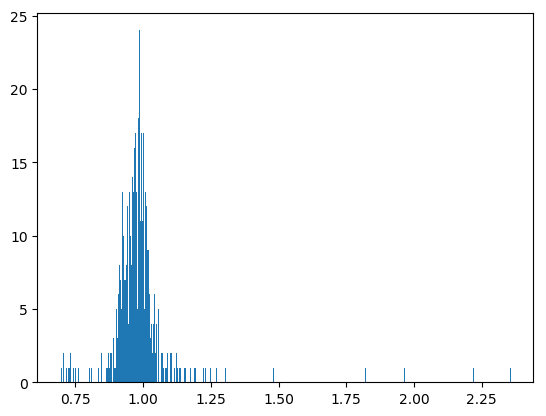

([1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.692891, 0.694557, 0.696222, 0.697888, 0.699553, 0.701218, 0.702884, 0.704549, 0.706214, 0.70788  …  2.34328, 2.34495, 2.34661, 2.34828, 2.34995, 2.35161, 2.35328, 2.35494, 2.35661, 2.35827], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0xa636d70f0>, PyObject <matplotlib.patches.Rectangle object at 0xa636dfeb8>, PyObject <matplotlib.patches.Rectangle object at 0xa636d76d8>, PyObject <matplotlib.patches.Rectangle object at 0xa636d7a58>, PyObject <matplotlib.patches.Rectangle object at 0xa636d7dd8>, PyObject <matplotlib.patches.Rectangle object at 0xa636e2198>, PyObject <matplotlib.patches.Rectangle object at 0xa636e2518>, PyObject <matplotlib.patches.Rectangle object at 0xa636e2898>, PyObject <matplotlib.patches.Rectangle object at 0xa636e2c18>, PyObject <matplotlib.patches.Rectangle object at 0xa636e2f98>  …  PyObject <matplotlib.patches.Rectangle object at 0x

In [207]:
PyPlot.plt[:hist](sort(normconstest[:])[2:end-1], bins=1000);

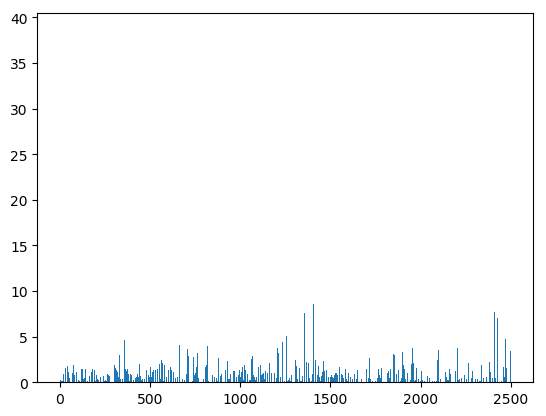

In [265]:
bar(range(1,stop=2500), W);

In [313]:
println("Effective Sum of Squares: " * sprintf1("%.3f", eff_ss(W)) * 
    "\nNormalised Perplexity: " * sprintf1("%.6f", weight_perp(W)))

Effective Sum of Squares: 622.016
Normalised Perplexity: 0.906672


## Adaptive Mixture Importance Sampling
The above appears reasonably good at finding modes of the posterior. This is a great initialisation for an adaptive mixture model approach.

We proceed by taking (weighted) kmeans of the samples generated, and using to fit a GMM. We can then iterate with generating from a (tilted) GMM and updating the components.

#### Defining functions for testing convergence of EM.
These are not that useful in practice since (1) we are not monotonic, (2) it is expensive.

Not sure if these functions are broken or whether my GMM implementation is broken.
    
<span style="color:red"><b>TODO: RESAMPLE AND TRY GMM WITH UNIT WEIGHTS AND UNINFORMATIVE PRIOR. DOES THIS WORK? ABLATION STUDY?</b></span>

In [801]:
function gmm_llh(X, weights, pis, mus, sigmas)
    n, p = size(X)
    k = length(pis)
    
    P = zeros(n, k)
    for j = 1:k
        P[:,j] = logpdf(MvNormal(mus[j,:], sigmas[:,:,j]), X')'
    end
    P .*= weights
    return logsumexprows(P)
end

function gmm_prior_llh(pis, mus, sigmas, pi_prior, mu_prior, cov_prior)
    d = size(cov_prior, 1)
    ν = pi_prior # alias
    k = length(pis)
    out = zeros(k)
    for j = 1:k
        out[j] += logpdf(MvNormal(mu_prior[j,:], sigmas[:,:,j]/ν[j]), mus[j,:])
        out[j] += -(ν[j] + d + 1)*logdet(sigmas[:,:,j])/2 
        out[j] += -ν[j]*sum(diag(cov_prior[:,:,j]*inv(sigmas[:,:,j])))/2
        out[j] += (ν[j] - 1)*log(pis[j])
    end
    return sum(out)
end


# ==> THIS FUNCTION IS **SO** MUCH FASTER THAN USING MVNORMAL, ALTHOUGH PERHAPS
# IS KIND OF BAD WHEN SIGMA IS NOT HERMITIAN... <===
function _log_gauss_llh(X, mu, sigma)
    d = size(X,2)
    invUT = Matrix(cholesky(inv(sigma)).U)
    Z = (X .- mu')*invUT'
    exponent = -0.5*sum(Z.^2, dims=2)
    lognormconst = -d*log(2*pi)/2 -0.5*logdet(sigma) #.+ sum(log.(diag(invUT)))
    return exponent .+ lognormconst
end

_log_gauss_llh (generic function with 1 method)

In [477]:
gmm_llh(S, W, ones(6)/6, cmus, ccovs)

-4051.753070792093

#### Rolling my own EM implementation for GMM
since (a) julia versions break in 1.0, and (b) need to add weights; and (c) need to add priors.

In [738]:
function gmm_custom(X, weights, pi_prior, mu_prior, cov_prior; max_iter=100, tol=1e-3)
    n, p = size(X)
    k = length(pi_prior)
    @assert size(weights) == (n,)
    @assert size(mu_prior) == (k, p)
    @assert size(cov_prior) == (p, p, k)
    pis = pi_prior/sum(pi_prior)
    mus = copy(mu_prior)
    sigmas = copy(cov_prior)

    weights = weights / mean(weights)   # diff. to Cappé et al. due to prior
    llh_hist = zeros(max_iter)
    
    for i in range(1, stop=max_iter)
        # E-step
        rs = reduce(hcat, map(j -> _log_gauss_llh(X, mus[j,:], sigmas[:,:,j]) .+ log(pis[j]), 1:k))
        rs = abutils.softmax2(rs, dims=2)
        
        # reweight according to importance weights (see Adaptive IS in General Mix. Cappé et al. 2008)
        rs .*= weights
        
        # M-step
        Ns = sum(rs, dims=1)
        pis = Ns' + pi_prior
        pis /= sum(pis)
        
        mus = reduce(vcat, map(j -> sum(X .* rs[:,j], dims=1) .+ pi_prior[j]*mu_prior[j,:]', 1:k))
        mus ./= Ns' + pi_prior
        
        for j in range(1, stop=k)
            Δx = X .- mus[j, :]'
            Δμ = (mus[j,:] - mu_prior[j,:])'
            sigmas[:,:,j] = (Δx.*rs[:,j])'Δx + pi_prior[j]*(Δμ'Δμ + cov_prior[:,:,j])
            sigmas[:,:,j] ./= (Ns[j] + pi_prior[j] + p + 2)
            sigmas[:,:,j] = (sigmas[:,:,j] + sigmas[:,:,j]')/2
        end

#         # update complete log likelihoood
#         llh_hist[i] = sum(gmm_llh(S, W, pis, mus, sigmas)) +
#                       gmm_prior_llh(pis, mus, sigmas, pi_prior, mu_prior, cov_prior)

        if i> 1 && abs(llh_hist[i] - llh_hist[i-1]) < tol
            println("Finished")
            break
        end
    end
    
    return pis, mus, sigmas, llh_hist
end

function sample_from_gmm(n, pis, mus, covs; shuffle=true)
    k, p = size(mus)
    Ns = rand(Multinomial(n, pis[:]))
    ixs = hcat(vcat(1, 1 .+ cumsum(Ns[1:end-1], dims=1)), cumsum(Ns, dims=1))
    out = zeros(n, p)
    for j=1:k
        out[ixs[j,1]:ixs[j,2],:] = rand(MvNormal(mus[j,:], covs[:,:,j]), Ns[j])'
    end
    if shuffle
        out = out[randperm(n),:]
    end
    return out
end

sample_from_gmm (generic function with 2 methods)

#### My rolled version of the AMIS algorithm

<span style="color:red"><b>TODO: VARIANCES SEEM TO BLOW UP OVER ITERATIONS. IS THIS TO DO WITH THE TILT? OR THE EM IMPLEMENTATION?</b></span>

In [774]:
function AMIS(S, W, k; nodisp=true)
    IS_tilt = 2.0
    n, p = size(S)
    
    km = kmeans(copy(S'), k, weights=W)
    
    cmus = zeros(k,2)
    ccovs = zeros(2,2,k)
    for i in range(1, stop=k)
        ixs = findall(x -> isequal(x,i), km.assignments)
        cX = S[ixs, :]; cw = ProbabilityWeights(W[ixs])
        cmus[i,:] = cX' * cw/cw.sum
        ccovs[:,:,i] = cov(cX, cw, corrected=true)
    end
    cpis = [countmap(km.assignments)[i] for i in 1:6]/10
    
    if !nodisp
        f, axs = PyPlot.subplots(5,2, figsize=(8,12))

        plot_level_curves_all(mus, UTs, ax=axs[1,1], color="red")
        for i = 1:k
            axs[1,1][:plot](splat(gaussian_2D_level_curve(cmus[i,:], ccovs[:,:,i]))...);
        end
    end
    
    ν_S = S; ν_W = W;
    nsmp=1000
    
    for i = 1:3
        cpis, cmus, ccovs, llh_hist = gmm_custom(ν_S, ν_W, cpis, cmus, ccovs; max_iter=10, tol=1e-3);
        ν_S = sample_from_gmm(1000, cpis, cmus, ccovs*IS_tilt, shuffle=false)
        ν_W = p_log_target(ν_S) - gmm_llh(ν_S, 1, cpis, cmus, ccovs*IS_tilt)
        @noopwhen (nodisp || i > 9) ax = axs[(i ÷ 2) + 1, (i % 2)+1]
        @noopwhen (nodisp || i > 9) plot_is_vs_target(ν_S, abutils.fastexp.(ν_W), ax=ax)
        @noopwhen (nodisp || i > 9) for j = 1:6 ax[:plot](splat(gaussian_2D_level_curve(cmus[j,:], ccovs[:,:,j]))...); end
    end
    return ν_S, ν_W, cpis, cmus, ccovs
end

AMIS (generic function with 1 method)

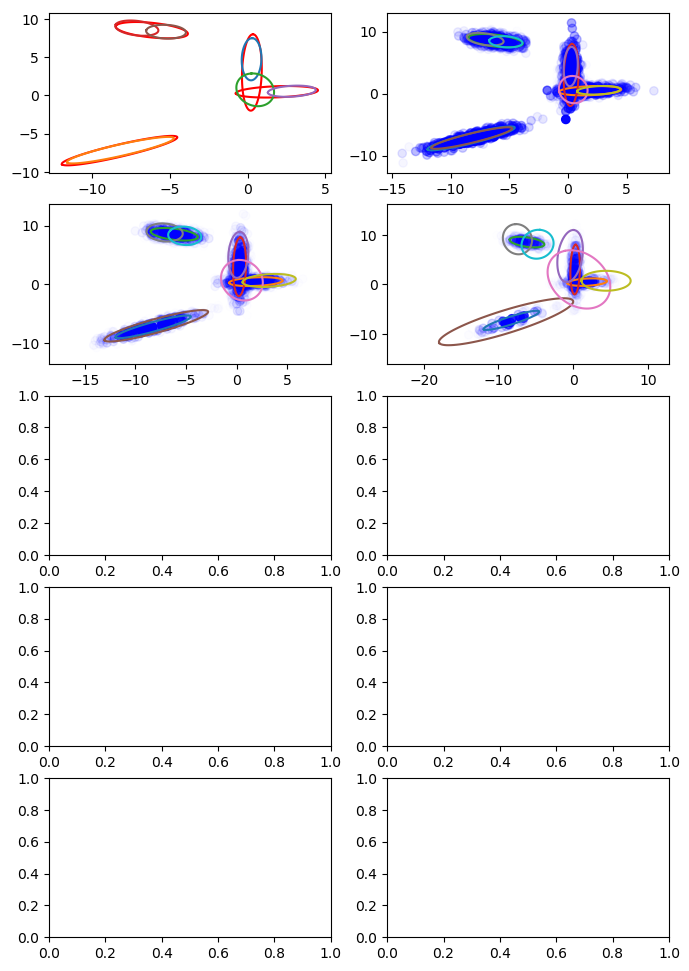

Finished
Finished
Finished
  0.139950 seconds (72.87 k allocations: 16.598 MiB, 5.49% gc time)


([0.676234 3.00808; 1.64677 9.14077; … ; -6.27782 13.1069; -5.12166 8.65764], [-0.317419, -9.55846, 0.329758, -4.42129, -6.32851, -1.66094, -7.84425, -8.8199, 0.31495, -21.9724  …  -10.4807, -12.3151, -47.7684, -3.84038, -46.2594, -4.96731, -10.0947, -15.8715, -42.6171, -0.495344], [0.0616358; 0.117854; … ; 0.0422792; 0.116015], [-0.39997 5.71652; -8.96875 -7.50226; … ; 4.40997 0.746327; -4.75794 8.10098], [0.730647 0.571021; 0.571021 6.89807]

[20.1839 9.12077; 9.12077 5.58949]

[4.39853 -1.56715; -1.56715 8.62971]

[0.946694 -0.121209; -0.121209 2.31205]

[2.71363 -0.00915188; -0.00915188 1.00154]

[1.14926 0.1113; 0.1113 2.11541])

In [776]:
@time _S, _W, _pi, _mu, _cov = AMIS(S, W, 6, nodisp=false)

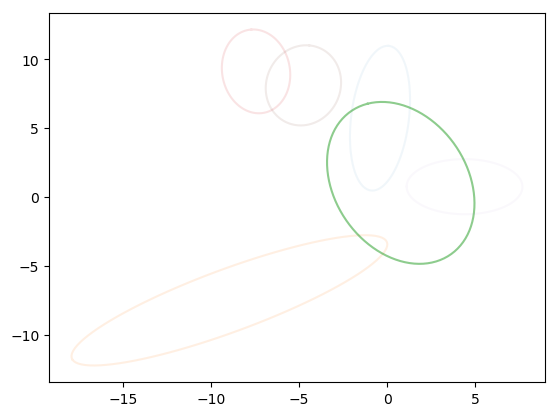

In [778]:
for j = 1:6; plot(splat(gaussian_2D_level_curve(_mu[j,:], _cov[:,:,j]))..., alpha=_pi[j]); end

In [779]:
mean(_W)

-13.065259475992866

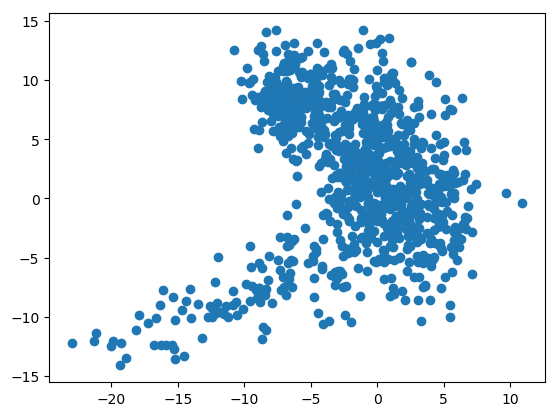

PyObject <matplotlib.collections.PathCollection object at 0xa7c101fd0>

In [777]:
scatter(splat(_S)...)

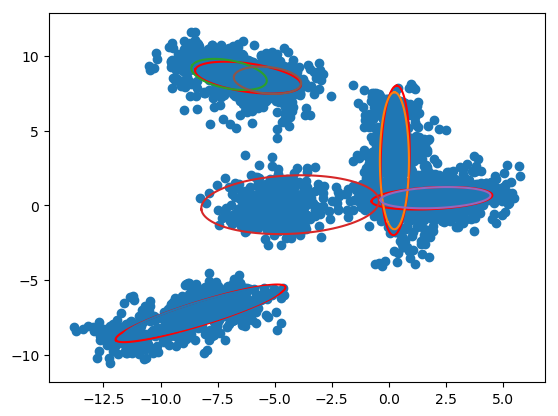

PyObject <matplotlib.collections.PathCollection object at 0xa49b0cdd8>

In [535]:
ax = gca()
plot_level_curves_all(mus, UTs, ax=ax, color="red")
for i = 1:6
    ax[:plot](splat(gaussian_2D_level_curve(νmus[i,:], νsigmas[:,:,i]))...);
end
ax[:scatter](splat(S2)...)

# Du BANANE!

<span style="color:red"><b>TODO: GOES INFINITE: BAD!</b></span>

In [781]:
function p_log_banana(X)
    b = 100
    s = 0.03
    return -X[:,1]/(2*s) - 0.5*(X[:,2] - b.*(X[:,1].^2 .- s)).^2
end

function p_log_banana_beta(x, beta)
    f_x = p_log_banana(x)
    return (1-beta)*p_log_prop(x) + beta*f_x, f_x
end

p_log_banana_beta (generic function with 1 method)

In [784]:
p_log_banana([1 2; 3 4; 0 0])

3-element Array{Float64,1}:
   -4529.166666666667
 -398774.5000000001  
      -4.5           

In [797]:
c_opts = smcs_opt(resample_every=10, betas=range(0.01, stop=1., length=50), 
    burnin=50, test=true, grad_delta=1.0, sqrtdelta=0.5)
S, W = smcs_grad(80, 50, p_log_banana_beta, opts=c_opts)

50×4 Array{Float64,2}:
 0.0  0.0  0.0  -357443.0      
 0.0  0.0  0.0  -296633.0      
 0.0  0.0  0.0   -16887.1      
 0.0  0.0  0.0       -1.01654e5
 0.0  0.0  0.0    -1098.97     
 0.0  0.0  0.0   -10370.8      
 0.0  0.0  0.0       -8.25683e5
 0.0  0.0  0.0   -35585.8      
 0.0  0.0  0.0       -2.36995e6
 0.0  0.0  0.0   -42079.6      
 0.0  0.0  0.0       -3.16794e5
 0.0  0.0  0.0       -2.40203e5
 0.0  0.0  0.0       -3.05443e5
 ⋮                             
 0.0  0.0  0.0       -4.54091e6
 0.0  0.0  0.0       -7.21912e5
 0.0  0.0  0.0      -26.1324   
 0.0  0.0  0.0       -4.02225e5
 0.0  0.0  0.0   -27816.5      
 0.0  0.0  0.0    -9018.69     
 0.0  0.0  0.0       -1.46386e6
 0.0  0.0  0.0       -1.84012e5
 0.0  0.0  0.0       -2.37415e6
 0.0  0.0  0.0     -915.362    
 0.0  0.0  0.0       -7.89325e6
 0.0  0.0  0.0     -619.462    

LoadError: Loss is Inf